## Importing libraries and files

In [1]:
import pandas as pd
from keras.models import load_model
import pickle
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from prettytable import PrettyTable

ann_arr = load_model('RP_Arrival_time/Arrival_ANN4')
ann_end = load_model('RP_End_time/End_ANN4')
ann_chg = load_model('RP_Change_time/Change_ANN1')

#Section1
ann1 = load_model('RP_Section_1_new3/Section1_new3_ANN_2')
sc1 = pickle.load(open('RP_Section_1_new3/Section1_new3_scaler_ANN_2.pkl', 'rb'))
#Section2
ann2 = load_model('RP_Section_2_new2/Section2_new_ANN_2')
sc2 = pickle.load(open('RP_Section_2_new/Section2_new_scaler_ANN_2.pkl', 'rb'))
#Section3
ann3 = load_model('RP_Section_3_new/Section3_new_ANN_2')
sc3 = pickle.load(open('RP_Section_3_new/Section3_new_scaler_ANN_2.pkl', 'rb'))
#Section4
ann4 = load_model('RP_Section_4_new/Section4_new_ANN_7')
sc4 = pickle.load(open('RP_Section_4_new/Section4_new_scaler_ANN_7.pkl', 'rb'))
#Section5
ann5 = load_model('RP_Section_5_new/Section5_new_ANN_4')
sc5 = pickle.load(open('RP_Section_5_new/Section5_new_scaler_ANN_4.pkl', 'rb'))
#Section6
ann6 = load_model('RP_Section_6_new/Section6_new_ANN_2')
sc6 = pickle.load(open('RP_Section_6_new/Section6_new_scaler_ANN_2.pkl', 'rb'))

## Input details

In [21]:
Mass = 15.8
Standoff_distance = 2.2
Angle = 0
start_time = 0.947713
termination_time = 14
interval = 0.0028
Time_adj = 0
Pressure_adj = 101.25

## Pressure Profile

In [22]:
arr = np.array ([[Mass,Standoff_distance, Angle]])

arrival_time = ann_arr.predict(arr)
end_time = ann_end.predict(arr)
change_time = ann_chg.predict(arr)

print ("arrival", arrival_time, "end", end_time, "change", change_time)

def stable_state(start, end, interval):    
    t = np.arange(start, end + interval, interval)
    t = t.reshape(len(t),1)

    p = np.repeat(0, len(t)).reshape(len(t),1)
    
    values = np.concatenate ((t, p), axis = 1)
    return values

def p_fluctuation(standoff_distance, d_set):
    if 1.5 <= standoff_distance <= 3:
        d_set[:,0:4] = sc1.transform(d_set[:,0:4])
        p_f = ann1.predict(d_set)
        section = 1
        
    elif 3 < standoff_distance <= 7:
        d_set[:,0:4] = sc2.transform(d_set[:,0:4])
        p_f = ann2.predict(d_set)
        section = 2
        
    elif 7 < standoff_distance <= 13:
        d_set[:,0:4] = sc3.transform(d_set[:,0:4])
        p_f = ann3.predict(d_set)
        section = 3
        
    elif 13 < standoff_distance <= 19:
        d_set[:,0:4] = sc4.transform(d_set[:,0:4])
        p_f = ann4.predict(d_set)
        section = 4
        
    elif 19 < standoff_distance <= 25:
        d_set[:,0:4] = sc5.transform(d_set[:,0:4])
        p_f = ann5.predict(d_set)
        section = 5
        
    elif 25 < standoff_distance <= 30:
        d_set[:,0:4] = sc6.transform(d_set[:,0:4])
        p_f = ann6.predict(d_set)
        section = 6
        
    else:
        print ("Out of trained range")
    return p_f, section

if termination_time < arrival_time:
    start = start_time
    end = termination_time
    values1 = stable_state(start, end, interval)
    arrival_time = 0
    end_time = 0

else:
    start = start_time
    end = arrival_time
    values1 = stable_state(start, end, interval)
    
    if termination_time < end_time:
        end_time = termination_time
        
    else:
        start = end_time
        end = termination_time
        values3 = stable_state(start, end, interval)

t2= np.arange(arrival_time, end_time + interval, interval)
t2 = t2.reshape(len(t2),1)

if t2[0] < change_time:
    ph2 = np.array([[0, 1]])
else:
    ph2 = np.array([[1, 0]])
    
positive = np.array([0, 1])
negative= np.array([1, 0])

for time in t2[1:]:
    if time < change_time:
        ph2=np.vstack((ph2,positive))
    else:
        ph2=np.vstack((ph2,negative))
        
m2 = np.repeat(Mass, len(t2)).reshape(len(t2),1)
d2 = np.repeat(Standoff_distance, len(t2)).reshape(len(t2),1)
a2 = np.repeat(Angle, len(t2)).reshape(len(t2),1)
d_set = np.concatenate ((m2, d2, a2, t2, ph2), axis = 1)

#p2 = p_fluctuation(Standoff_distance, d_set)
p2, section = p_fluctuation(Standoff_distance, d_set)
p2 = p2.reshape((-1, 1))
values2 = np.concatenate ((t2, p2), axis = 1)


if 'values2' in globals():
    ml_model = np.concatenate((values1, values2), axis=0)
    if 'values3' in globals():
        ml_model = np.concatenate((ml_model, values3), axis=0)
else:
    ml_model = values1
    
X1 = ml_model[:,0]
y1 = ml_model[:,1]
print (section)

1/1 [==============================] - 0s 39ms/step
arrival [[1.0994965]] end [[17.015318]] change [[2.809203]]
  1/145 [..............................] - ETA: 5s

C:\Users\z5379606\AppData\Local\Temp\ipykernel_32996\1261820028.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  t = np.arange(start, end + interval, interval)
C:\Users\z5379606\AppData\Local\Temp\ipykernel_32996\1261820028.py:73: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  t2= np.arange(arrival_time, end_time + interval, interval)


145/145 [==============================] - 0s 3ms/step
1


In [384]:
file_path = Path(f'G:/Chamodi/LSDYNA3D/RP_TH_models/RP_Comparison_with_Numerical/{Standoff_distance}m{Mass}kg/{Angle}')
lsdyna = pd.read_csv(file_path, delimiter="\s+", skiprows = 8, skipfooter = 1, header = None, names = ["Time", "Pressure"])

X2_original = lsdyna['Time']
y2_original = lsdyna['Pressure']

X2_original=(X2_original*1000)+ Time_adj
y2_original=(y2_original/1000)- Pressure_adj

# Find the indices for the two values closest to value1 and value2
index1 = (np.abs(X2_original - start_time)).argmin()
index2 = (np.abs(X2_original - termination_time)).argmin()

# Extract the ranges from X2 and y2 based on the indices
X2_original = X2_original[index1:index2+1]
y2_original = y2_original[index1:index2+1]

X2_original = X2_original.to_numpy()
y2_original = y2_original.to_numpy()

print("Numerical length",len(y2_original), "ANN-based length", len(y1))

Numerical length 1448 ANN-based length 1447


C:\Users\z5379606\AppData\Local\Temp\ipykernel_19004\4071666404.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  lsdyna = pd.read_csv(file_path, delimiter="\s+", skiprows = 8, skipfooter = 1, header = None, names = ["Time", "Pressure"])


In [327]:
X1=X1[:-1]
y1=y1[:-1]
print("ANN:",len(X1),"Num:",len(X2_original))
print("ANN:",len(y1),"Num:",len(y2_original))

ANN: 1344 Num: 1344
ANN: 1344 Num: 1344


In [386]:
X2_original=X2_original[:-1]
y2_original=y2_original[:-1]
print("ANN:",len(X1),"Num:",len(X2_original))
print("ANN:",len(y1),"Num:",len(y2_original))

ANN: 1447 Num: 1447
ANN: 1447 Num: 1447


In [5]:
print("ANN",X1)
print("Num",X2_original)

ANN [ 0.947713    0.957713    0.967713   ... 13.98948419 13.99948418
 14.00948417]
Num [ 0.947713   0.9498214  0.9519356 ... 13.99244   13.9964    14.00036  ]


In [23]:
file_path = Path(f'G:/Chamodi/LSDYNA3D/RP_TH_models/RP_Comparison_with_Numerical/{Standoff_distance}m{Mass}kg/{Angle}.xlsx')
lsdyna = pd.read_excel(file_path, names = ["Time", "Pressure"])

X2_original = lsdyna['Time']
y2_original = lsdyna['Pressure']

X2_original=(X2_original*1000)+ Time_adj
y2_original=(y2_original/1000)- Pressure_adj

# Find the indices for the two values closest to value1 and value2
index1 = (np.abs(X2_original - start_time)).argmin()
index2 = (np.abs(X2_original - termination_time)).argmin()

# Extract the ranges from X2 and y2 based on the indices
X2_original = X2_original[index1:index2+1]
y2_original = y2_original[index1:index2+1]

X2_original = X2_original.to_numpy()
y2_original = y2_original.to_numpy()

print("Numerical length",len(y2_original), "ANN-based length", len(y1))

Numerical length 4569 ANN-based length 4665


In [24]:
from scipy.signal import find_peaks

# Identify peaks with tolerance parameters
height_threshold = 0.1  # Minimum height of peaks to detect
prominence = 0.01  # Minimum prominence of peaks in pressure units
width = 5  # Minimum width of peaks in time units

# Find peaks
peaks, properties = find_peaks(y2_original, height=height_threshold, prominence=prominence, width=width)
print (peaks)

# Ensure there are at least two peaks
if len(peaks) >= 1:
    #first_peak_index = peaks[0]

    # Create a copy of pressure data to modify
    smoothed_pressure = np.copy(y2_original)

    # Define a window around each peak after the first peak to apply smoothing
    window_radius_r = 80
    window_radius_l = 30 # Adjust the window radius as needed
    selected_peaks = [peaks[2]]

    for peak_index in selected_peaks:
        start = max(peak_index - window_radius_l, 0)
        end = min(peak_index + window_radius_r + 1, len(y2_original))

        # Extract values just outside the window
        if start > 0 and end < len(y2_original):
            start_value = y2_original[start - 1]
            end_value = y2_original[end]
        elif start > 0:
            start_value = y2_original[start - 1]
            end_value = start_value
        elif end < len(y2_original):
            end_value = y2_original[end]
            start_value = end_value
        else:
            start_value = end_value = np.mean(y2_original)  # Fallback in case there are no valid points

        # Create a linearly spaced array between start_value and end_value
        interpolated_values = np.linspace(start_value, end_value, end - start)

        # Apply the interpolated values to the points within the window
        smoothed_pressure[start:end] = interpolated_values
        
y2 = smoothed_pressure
X2 = X2_original

plt.figure(figsize=(6,6))
plt.plot(X2_original,y2_original, color = 'blue',label = 'Numerical')
plt.plot(X2, y2, color = 'red',label = 'Numerical')
# Mark the peaks on the plot
plt.scatter(X2_original[peaks], y2_original[peaks], color='green', s=50, label='Peaks', zorder=5)
plt.show()

[ 52 354]


IndexError: index 2 is out of bounds for axis 0 with size 2

In [48]:
# Numerical
max_index_num = np.argmax(y2)
min_index_num = np.argmin(y2)

zero_crossing_index = next((i for i, val in enumerate(y2[max_index_num:min_index_num], start=0) if val <= 0), None)+max_index_num

change_time_num = X2[zero_crossing_index]


positive_duration_num = change_time_num - X2[max_index_num]
#negative_duration_num = end_time_num - change_time_num


positive_peak_pressure_num = y2[max_index_num]
negative_peak_pressure_num = y2[min_index_num]

positive_peak_time_num = X2[max_index_num]
negative_peak_time_num = X2[min_index_num]

# ANN-based
positive_duration_ann = float(change_time - arrival_time)
#negative_duration_ann = float(end_time - change_time)

max_index_ann = np.argmax(p2)
min_index_ann = np.argmin(p2)

positive_peak_pressure_ann = float(p2[max_index_ann])
negative_peak_pressure_ann = float(p2[min_index_ann])

positive_peak_time_ann = float(t2[max_index_ann])
negative_peak_time_ann = float(t2[min_index_ann])

C:\Users\z5379606\AppData\Local\Temp\ipykernel_25572\4178299979.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  positive_duration_ann = float(change_time - arrival_time)
C:\Users\z5379606\AppData\Local\Temp\ipykernel_25572\4178299979.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  positive_peak_pressure_ann = float(p2[max_index_ann])
C:\Users\z5379606\AppData\Local\Temp\ipykernel_25572\4178299979.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  negati

In [25]:
# Numerical
max_index_num = np.argmax(y2)
#min_index_num = np.argmin(y2)

zero_crossing_index = next((i for i, val in enumerate(y2[max_index_num:], start=0) if val <= 0), None)+max_index_num

change_time_num = X2[zero_crossing_index]

min_index_num = np.argmin(y2[zero_crossing_index:])+zero_crossing_index


positive_duration_num = change_time_num - X2[max_index_num]
#negative_duration_num = end_time_num - change_time_num


positive_peak_pressure_num = y2[max_index_num]
negative_peak_pressure_num = y2[min_index_num]

positive_peak_time_num = X2[max_index_num]
negative_peak_time_num = X2[min_index_num]

# ANN-based
positive_duration_ann = float(change_time - arrival_time)
#negative_duration_ann = float(end_time - change_time)

max_index_ann = np.argmax(p2)
min_index_ann = np.argmin(p2)

positive_peak_pressure_ann = float(p2[max_index_ann])
negative_peak_pressure_ann = float(p2[min_index_ann])

positive_peak_time_ann = float(t2[max_index_ann])
negative_peak_time_ann = float(t2[min_index_ann])

print (max_index_num, zero_crossing_index, min_index_num)

NameError: name 'y2' is not defined

In [8]:
plt.rcdefaults()

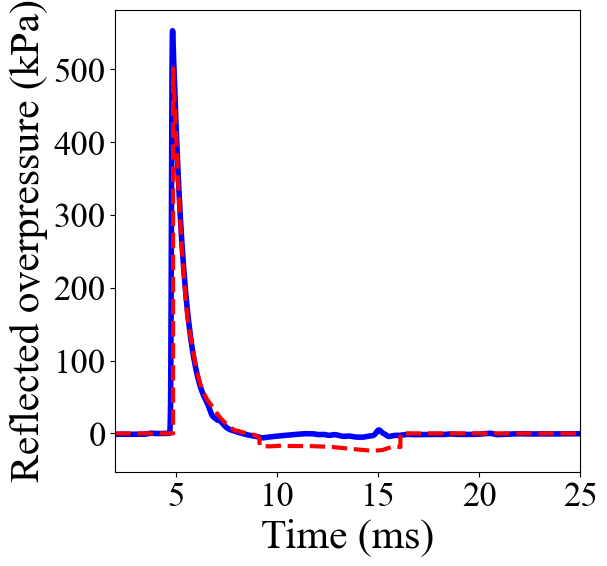

In [394]:
plt.figure(figsize=(6,6))
plt.rcParams["font.family"] = "Times New Roman"
plt.plot(X2, y2, color = 'blue',label = 'Numerical', linewidth=4)
plt.plot(X1, y1, linestyle = 'dashed', color = 'red', label = 'ANN framework', linewidth=3)
plt.ylabel('Reflected overpressure (kPa)',fontsize = 30)
plt.xlabel('Time (ms)',fontsize = 30)
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, frameon = False, fontsize = 20)

# Create the annotation text
#annotation_text = (f'Peak incident overpressure\n\nANN framework - {round(max(y1), 2)} kPa\n'
#                   f'Numerical - {round(max(y2), 2)} kPa')

#plt.annotate(annotation_text,xy=(0.4,0.5), xycoords='figure fraction', fontsize=18)

plt.xlim (start_time,termination_time)
plt.savefig(f'RP_Num&ANN_Comparison/Section{section}_{Standoff_distance}m{Mass}kg/{Angle}deg.png', dpi=150, bbox_inches='tight')
plt.show()

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000

ValueError: x and y must have same first dimension, but have shapes (101,) and (3,)

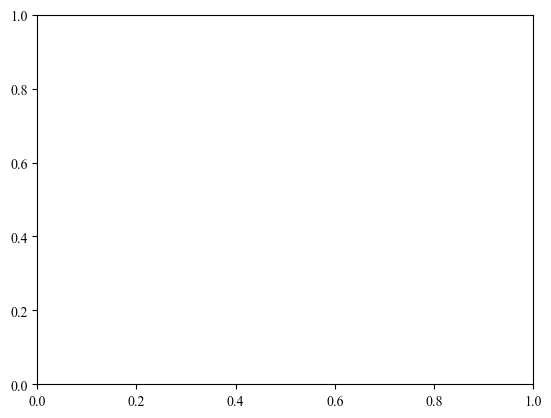

In [407]:
# Define the lag range
lag_range = 50

# Define the time range of interest
start_time = 0  # Start index of the time range
end_time = 700    # End index of the time range

# Subset the time series data to the desired time range
y1_range = y1[start_time:end_time]
y2_range = y2[start_time:end_time]
print (y1[start_time:end_time])
y1_centered = y1_range - np.mean(y1_range)
y2_centered = y2_range - np.mean(y2_range)

cross_corr_full = np.correlate(y2_centered, y1_centered, mode='full')
#cross_corr_full = np.correlate(y2, y1, mode='full')

# Find the middle index (corresponds to zero lag)
mid_idx = len(y2) - 1

# Extract the cross-correlation only within the desired lag range (-50 to 50)
cross_corr_limited = cross_corr_full[mid_idx - lag_range: mid_idx + lag_range + 1]

# Normalize the cross-correlation coefficient
# The normalization uses the standard deviations of y2 and y1 and the length of the y2 series
norm_cross_corr = cross_corr_limited / (np.std(y2) * np.std(y1) * len(y2))

# Define the lags between -50 and 50
lags = np.arange(-lag_range, lag_range + 1)

# Find the lag that gives the maximum correlation within the restricted range
max_corr_lag = lags[np.argmax(np.abs(norm_cross_corr))]

# Plot the cross-correlation for the limited range
plt.plot(lags, norm_cross_corr)
plt.axvline(0, color='black', linestyle='--', label="Zero lag")
plt.axvline(max_corr_lag, color='red', linestyle='--', label=f"Max Corr Lag = {max_corr_lag}")
plt.xlabel('Lag')
plt.ylabel('Cross-correlation coefficient')
plt.title('Cross-Correlation between Numerical Model and ANN Prediction')
plt.legend()
plt.show()

# Check the correlation at zero lag
zero_lag_corr = norm_cross_corr[lag_range]
print(f"Cross-correlation coefficient at zero lag: {zero_lag_corr}")
max_corr_value = norm_cross_corr[np.argmax(np.abs(norm_cross_corr))]
max_corr_lag_time = max_corr_lag*interval
print(f"Max cross-correlation coefficient lag: {max_corr_lag} = {max_corr_lag_time}: {max_corr_value}")


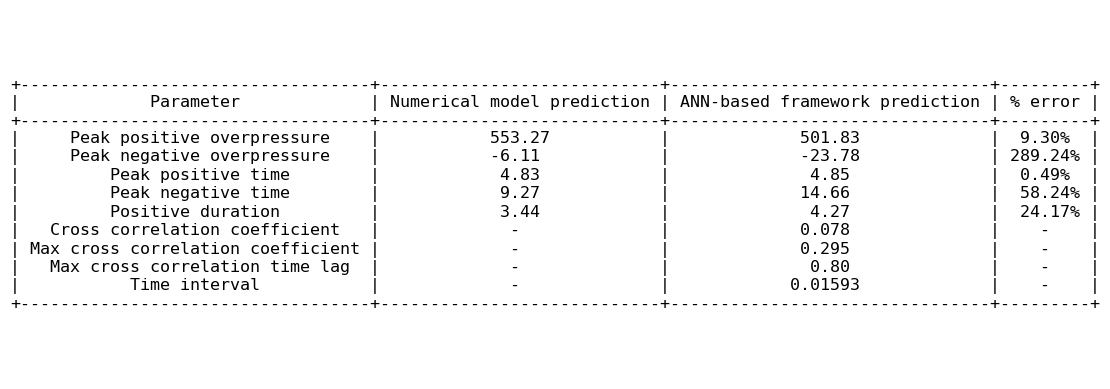

In [397]:
# Initialize PrettyTable
table = PrettyTable()

# Define columns
table.field_names = ["Parameter", "Numerical model prediction", "ANN-based framework prediction", "% error"]

# Calculate percentage errors
def per_error(true_value, predicted_value):
    return abs(predicted_value - true_value) / abs(true_value) * 100

# Add rows
table.add_row(["Peak positive overpressure", f"{positive_peak_pressure_num:.2f}", f"{positive_peak_pressure_ann:.2f}", f"{per_error(positive_peak_pressure_num, positive_peak_pressure_ann):.2f}%"])
table.add_row(["Peak negative overpressure", f"{negative_peak_pressure_num:.2f}", f"{negative_peak_pressure_ann:.2f}", f"{per_error(negative_peak_pressure_num, negative_peak_pressure_ann):.2f}%"])
table.add_row(["Peak positive time", f"{positive_peak_time_num:.2f}", f"{positive_peak_time_ann:.2f}", f"{per_error(positive_peak_time_num, positive_peak_time_ann):.2f}%"])
table.add_row(["Peak negative time", f"{negative_peak_time_num:.2f}", f"{negative_peak_time_ann:.2f}", f"{per_error(negative_peak_time_num, negative_peak_time_ann):.2f}%"])
table.add_row(["Positive duration", f"{positive_duration_num:.2f}", f"{positive_duration_ann:.2f}", f"{per_error(positive_duration_num, positive_duration_ann):.2f}%"])
#table.add_row(["Negative duration", f"{negative_duration_num:.2f}", f"{negative_duration_ann:.2f}", f"{per_error(negative_duration_num, negative_duration_ann):.2f}%"])
table.add_row(["Cross correlation coefficient", "-", f"{zero_lag_corr:.3f}", "-"])
table.add_row(["Max cross correlation coefficient", "-", f"{max_corr_value:.3f}", "-"])
table.add_row(["Max cross correlation time lag", "-", f"{max_corr_lag_time:.2f}", "-"])
table.add_row(["Time interval", "-", f"{interval:}", "-"])

# Convert PrettyTable to string
table_str = table.get_string()

# Set up Matplotlib figure and axes
fig, ax = plt.subplots()

# Hide axes
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Use the table_str as the plot text
ax.text(0.5, 0.5, table_str, fontsize=12, ha="center", va="center", family="monospace")

# Save the table as an image
plt.savefig(f'RP_Num&ANN_Comparison/Section{section}_{Standoff_distance}m{Mass}kg/table_{Angle}deg.png', dpi=150, bbox_inches='tight')

# Show the plot (optional)
plt.show()